In [15]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to your dataset
base_path = "/content/drive/MyDrive/augmented_dataset"

train_images = os.path.join(base_path, "images/train")
train_masks  = os.path.join(base_path, "masks/train")

val_images = os.path.join(base_path, "images/valid")
val_masks  = os.path.join(base_path, "masks/valid")

test_images = os.path.join(base_path, "images/test")
test_masks  = os.path.join(base_path, "masks/test")

print("Train Images:", train_images)
print("Train Masks:", train_masks)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Images: /content/drive/MyDrive/augmented_dataset/images/train
Train Masks: /content/drive/MyDrive/augmented_dataset/masks/train


In [16]:
!pip install segmentation-models-pytorch albumentations --quiet


In [17]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Extract base names without extensions for matching
        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)

        image_stems = {os.path.splitext(f)[0]: f for f in image_files if f.endswith(('.jpg', '.png', '.jpeg'))}
        mask_stems  = {os.path.splitext(f)[0]: f for f in mask_files if f.endswith(('.jpg', '.png', '.jpeg'))}

        # Keep only matching pairs
        matched_keys = sorted(list(set(image_stems.keys()) & set(mask_stems.keys())))
        self.images = [image_stems[k] for k in matched_keys]
        self.masks  = [mask_stems[k] for k in matched_keys]

        print(f"[INFO] Found {len(self.images)} matching image-mask pairs.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask


In [18]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define class remapping dictionary (example values)
class_map = {
    0: 0,       # background
    81: 1,      # class 1
    128: 2,     # class 2
    255: 3      # class 3
}
NUM_CLASSES = len(class_map)

def remap_mask(mask):
    remapped = np.zeros_like(mask)
    for original, new_class in class_map.items():
        remapped[mask == original] = new_class
    return remapped

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)

        image_stems = {os.path.splitext(f)[0]: f for f in image_files if f.endswith(('.jpg', '.png'))}
        mask_stems  = {os.path.splitext(f)[0]: f for f in mask_files if f.endswith(('.jpg', '.png'))}

        matched_keys = sorted(set(image_stems.keys()) & set(mask_stems.keys()))
        self.images = [image_stems[k] for k in matched_keys]
        self.masks  = [mask_stems[k] for k in matched_keys]

        print(f"[INFO] Found {len(self.images)} matching image-mask pairs.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = remap_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()

        return image, mask


In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Dataset and DataLoader
train_dataset = RoadDataset(train_images, train_masks, transform=transform)
val_dataset   = RoadDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


[INFO] Found 1072 matching image-mask pairs.
[INFO] Found 66 matching image-mask pairs.


In [20]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


In [21]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    for i, (imgs, masks) in enumerate(loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 0:
            print(f"[Batch {i}/{len(loader)}] Loss: {loss.item():.4f}")

    return running_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

# Train the model
for epoch in range(3):  # or more
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


[Batch 0/268] Loss: 1.3795
[Batch 10/268] Loss: 1.1947
[Batch 20/268] Loss: 0.9944
[Batch 30/268] Loss: 0.9521
[Batch 40/268] Loss: 0.8108
[Batch 50/268] Loss: 0.6550
[Batch 60/268] Loss: 0.5281
[Batch 70/268] Loss: 0.5144
[Batch 80/268] Loss: 0.4229
[Batch 90/268] Loss: 0.3733
[Batch 100/268] Loss: 0.3675
[Batch 110/268] Loss: 0.3820
[Batch 120/268] Loss: 0.3269
[Batch 130/268] Loss: 0.2637
[Batch 140/268] Loss: 0.3117
[Batch 150/268] Loss: 0.2480
[Batch 160/268] Loss: 0.5241
[Batch 170/268] Loss: 0.2307
[Batch 180/268] Loss: 0.2708
[Batch 190/268] Loss: 0.2076
[Batch 200/268] Loss: 0.2613
[Batch 210/268] Loss: 0.2010
[Batch 220/268] Loss: 0.2212
[Batch 230/268] Loss: 0.2093
[Batch 240/268] Loss: 0.2412
[Batch 250/268] Loss: 0.1414
[Batch 260/268] Loss: 0.1734
Epoch 1: Train Loss = 0.4276, Val Loss = 0.1814
[Batch 0/268] Loss: 0.1814
[Batch 10/268] Loss: 0.1773
[Batch 20/268] Loss: 0.1816
[Batch 30/268] Loss: 0.1601
[Batch 40/268] Loss: 0.1593
[Batch 50/268] Loss: 0.1246
[Batch 60/268

In [22]:
def predict_mask(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dim
        output = model(image_tensor)  # Shape: [1, C, H, W]
        output = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # Shape: [H, W]
    return output


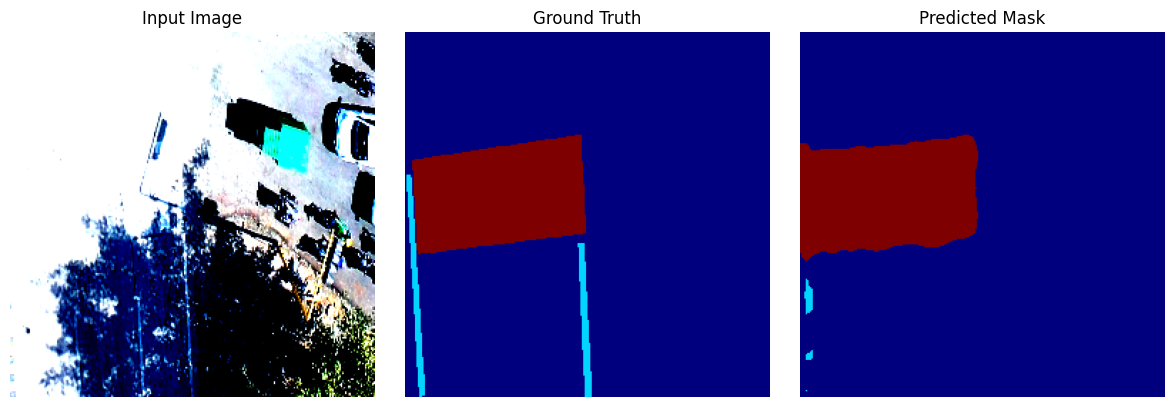

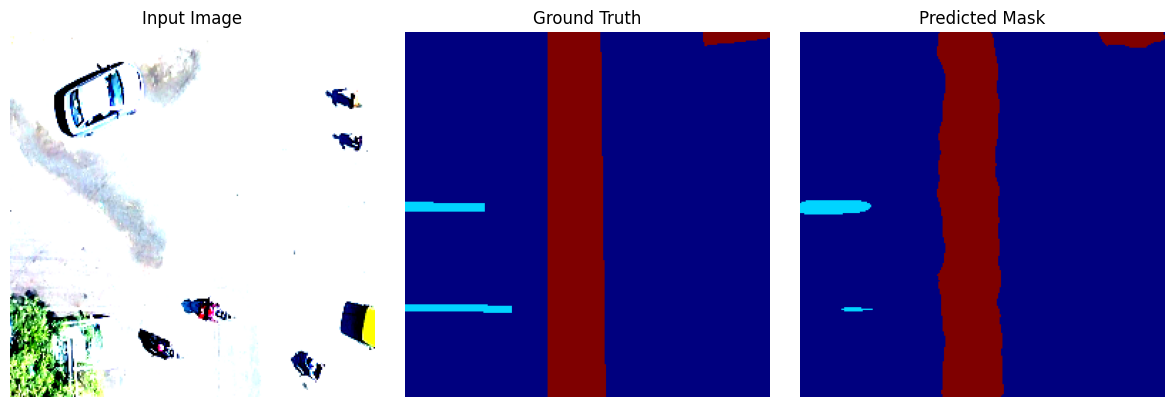

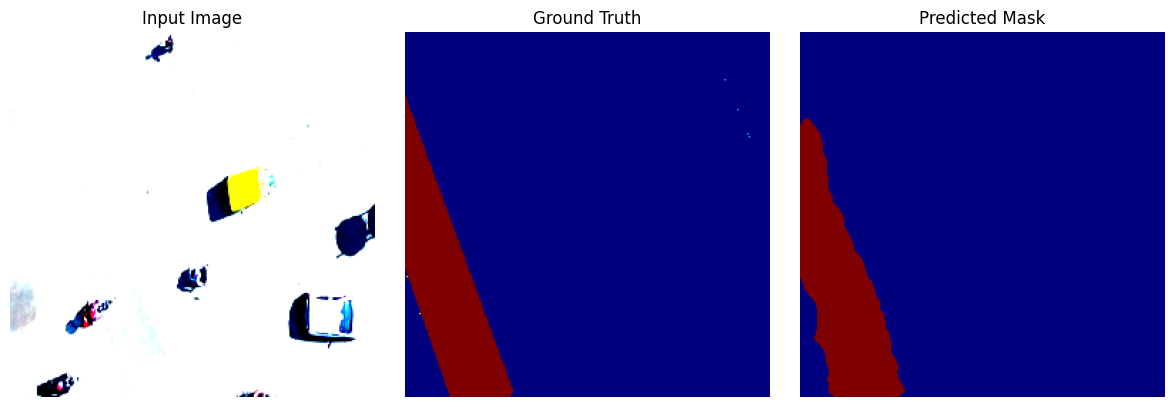

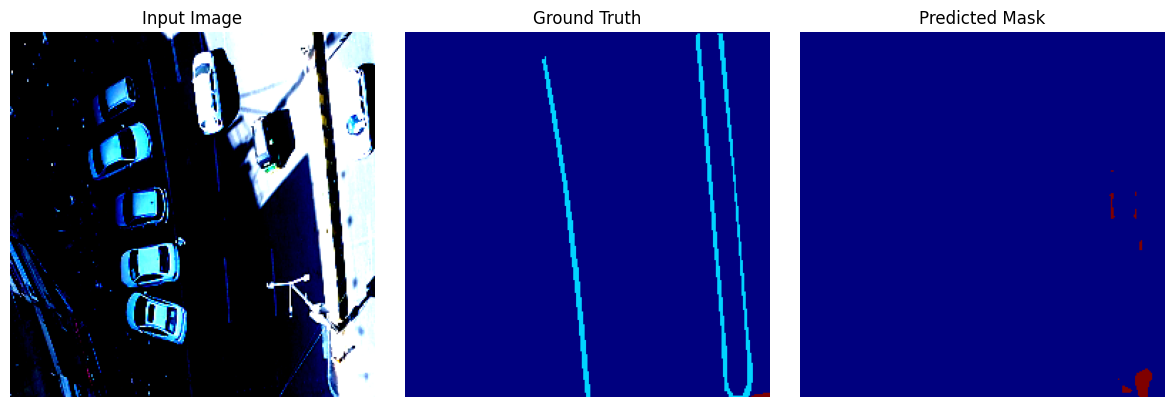

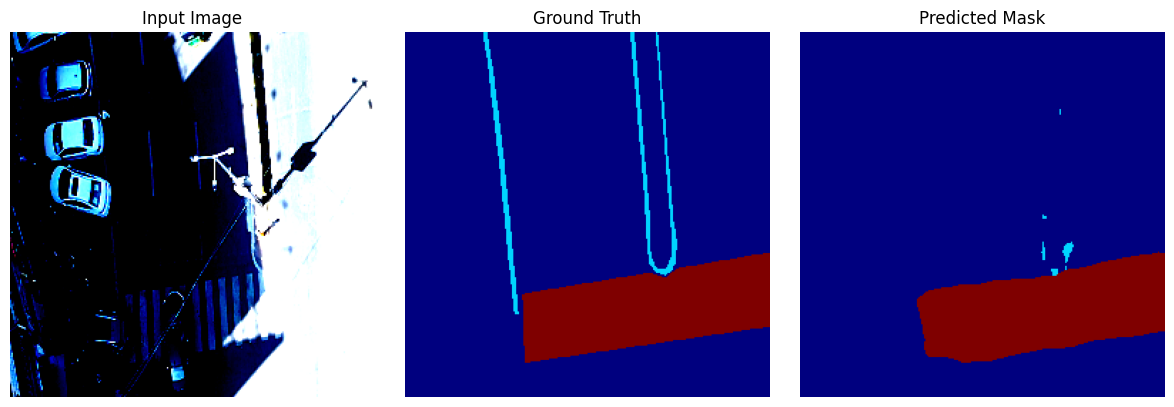

In [23]:
import matplotlib.pyplot as plt

# Show predictions for a few samples from the validation set
num_samples_to_show = 5

for i in range(num_samples_to_show):
    image, true_mask = val_dataset[i]  # Dataset returns tensors
    pred_mask = predict_mask(model, image)

    # Convert image to NumPy for plotting
    image_np = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.cpu(), cmap='jet')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [24]:
torch.save(model.state_dict(), "/content/drive/MyDrive/deeplabv3_roadmark.pth")
print("Model saved to Google Drive!")


Model saved to Google Drive!


In [25]:
import os
from PIL import Image
import numpy as np

# Create directory to store predictions
os.makedirs("saved_predictions", exist_ok=True)

def save_predictions(model, dataset, save_dir="saved_predictions", num=None):
    model.eval()
    total = len(dataset) if num is None else min(num, len(dataset))

    for i in range(total):
        image, _ = dataset[i]
        pred_mask = predict_mask(model, image)

        pred_img = Image.fromarray(pred_mask.astype(np.uint8))
        pred_img.save(os.path.join(save_dir, f"pred_{i}.png"))

    print(f"[INFO] Saved {total} predictions to '{save_dir}'")

# Save predictions from validation set
save_predictions(model, val_dataset)


[INFO] Saved 66 predictions to 'saved_predictions'


In [29]:
import segmentation_models_pytorch as smp
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 4  # update this based on your use case

# DeepLabV3+
model1 = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES
)
model1.load_state_dict(torch.load("/content/drive/MyDrive/deeplabv3_roadmark.pth"))
model1.to(device)



DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

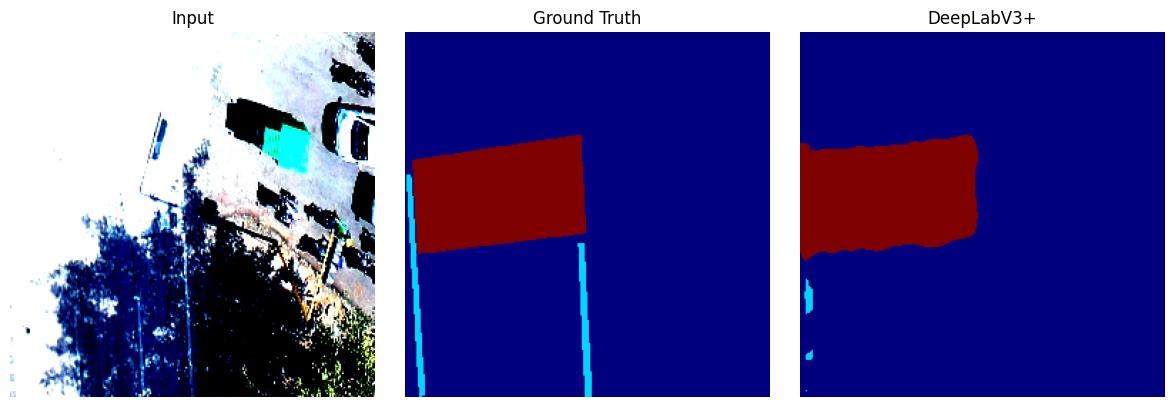

In [30]:
models = {
    "DeepLabV3+": model1,
    #"UNet": model2,
    # "SegFormer": model3  # Include only if available
}

sample_idx = 0
image, true_mask = val_dataset[sample_idx]
image_np = image.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(4 * (len(models) + 2), 4))
plt.subplot(1, len(models) + 2, 1)
plt.imshow(image_np)
plt.title("Input")
plt.axis("off")

plt.subplot(1, len(models) + 2, 2)
plt.imshow(true_mask, cmap="jet")
plt.title("Ground Truth")
plt.axis("off")

for i, (name, mdl) in enumerate(models.items(), start=3):
    pred_mask = predict_mask(mdl, image)
    plt.subplot(1, len(models) + 2, i)
    plt.imshow(pred_mask, cmap="jet")
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [37]:
def compute_metrics(model, dataloader, num_classes):
    model.eval()
    iou_per_class = np.zeros(num_classes)
    class_counts = np.zeros(num_classes)
    total_pixels = 0
    correct_pixels = 0

    print("[INFO] Starting metric computation...")

    with torch.no_grad():
        for batch_idx, (imgs, true_masks) in enumerate(dataloader):
            imgs = imgs.to(device)
            true_masks = true_masks.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            correct_pixels += (preds == true_masks).sum().item()
            total_pixels += torch.numel(true_masks)

            for cls in range(num_classes):
                pred_cls = (preds == cls)
                true_cls = (true_masks == cls)
                intersection = (pred_cls & true_cls).sum().item()
                union = (pred_cls | true_cls).sum().item()
                if union > 0:
                    iou_per_class[cls] += intersection / union
                    class_counts[cls] += 1

            print(f"[Batch {batch_idx+1}] processed.")

    if total_pixels == 0:
        print("[WARNING] No data found in dataloader.")
        return

    pixel_accuracy = correct_pixels / total_pixels
    mean_iou = (iou_per_class / np.maximum(class_counts, 1)).mean()

    print(f"\n Evaluation Metrics:")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Mean IoU     : {mean_iou:.4f}")

    for cls in range(num_classes):
        if class_counts[cls] > 0:
            class_iou = iou_per_class[cls] / class_counts[cls]
            print(f"Class {cls} IoU: {class_iou:.4f}")
        else:
            print(f"Class {cls} IoU: N/A (not present in batch)")


In [38]:
compute_metrics(model, val_loader, NUM_CLASSES)


[INFO] Starting metric computation...
[Batch 1] processed.
[Batch 2] processed.
[Batch 3] processed.
[Batch 4] processed.
[Batch 5] processed.
[Batch 6] processed.
[Batch 7] processed.
[Batch 8] processed.
[Batch 9] processed.
[Batch 10] processed.
[Batch 11] processed.
[Batch 12] processed.
[Batch 13] processed.
[Batch 14] processed.
[Batch 15] processed.
[Batch 16] processed.
[Batch 17] processed.

 Evaluation Metrics:
Pixel Accuracy: 0.9690
Mean IoU     : 0.5485
Class 0 IoU: 0.9661
Class 1 IoU: 0.3609
Class 2 IoU: 0.0000
Class 3 IoU: 0.8672
